In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
import tensorflow_probability as tfp
import h5py
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from DataMaker import HDF5ImageGenerator

In [2]:
import photoz_utils

In [3]:
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions

In [4]:
from tensorflow_probability.python.distributions import kl_divergence

In [5]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2022-09-27 14:14:33.368072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2022-09-27 14:14:33.373779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 14:14:33.374485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 14:14:33.376936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 14:14:33.378716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
LATENT_DIM = 16
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 128
EPOCHS = 5
GB_LIMIT = 30
CHECKPOINTS_TO_SAVE = 1

In [7]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': True,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': True}

train_gen = HDF5ImageGenerator(src='/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src='/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src='/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5', **args_gen)

In [8]:
n = BATCH_SIZE
l = len(train_gen._indices)

In [9]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype = dtype, initializer = lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable = True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t[ ..., : n],
                       scale = 0 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims = 1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype = dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t, scale = 0.01),
            reinterpreted_batch_ndims = 1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean = 0., stddev = 0.03)
    loc = tf.Variable(
        initial_value = loc_norm(shape = (n, ), dtype = dtype)
    )
    scale_norm = tf.random_normal_initializer(mean = -3., stddev = 0.1)
    scale = tf.Variable(
        initial_value = scale_norm(shape = (n, ), dtype = dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [10]:
import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [11]:
model_variational = Sequential([
    InputLayer(input_shape = (5, 127, 127)),
    tfpl.Convolution2DFlipout(32, kernel_size=(3, 3), activation = 'tanh', kernel_divergence_fn = kl_divergence_function, data_format = 'channels_first'),
    MaxPooling2D(2, 2, data_format = 'channels_first'),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh', data_format = 'channels_first'),
    MaxPooling2D(2, 2, data_format = 'channels_first'),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu', data_format = 'channels_first'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu', data_format = 'channels_first'),
    Flatten(),
    Dropout(0.2),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_variational.build((n, 5, 127, 127))

model_variational.summary()

/home/billyli/miniconda3/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/billyli/miniconda3/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout (Conv2DFlipo  (None, 32, 125, 125)     2912      
 ut)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 62, 62)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 32, 61, 61)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 30, 30)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 28, 28)        9248      
                                                        

In [12]:
def loss_function(targets, estimated_distribution):
    return - estimated_distribution.log_prob(targets) / (1 + targets)

model_variational.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])

In [13]:
import tensorboard

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

model_name = 'HSC_v6_BCNN_v6_full'

checkpoint_filepath = os.path.join('/models/', model_name)

weights_path = os.path.join('/models/', model_name) + '_weights'

log_directory = os.path.join('/logs/', model_name)

logs_callback = TensorBoard(log_dir = log_directory)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoint_filepath, 'weights_epoch{epoch}.hdf5'),
                                   save_freq = int(EPOCHS / CHECKPOINTS_TO_SAVE) * int(l / BATCH_SIZE),
                                   save_weights_only = True, save_best_only = True)

LR_callback = ReduceLROnPlateau()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_directory, histogram_freq = 1)

In [14]:
model_variational.fit(train_gen, epochs = EPOCHS, shuffle = True, verbose = 1, validation_data = val_gen, callbacks = [tensorboard_callback, logs_callback, LR_callback, weights_callback])

Layer DenseVariational has arguments ['self', 'units', 'make_posterior_fn', 'make_prior_fn', 'kl_weight', 'kl_use_exact', 'activation', 'use_bias', 'activity_regularizer']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Layer DenseVariational has arguments ['self', 'units', 'make_posterior_fn', 'make_prior_fn', 'kl_weight', 'kl_use_exact', 'activation', 'use_bias', 'activity_regularizer']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
   

2022-09-27 14:16:38.250692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-09-27 14:19:22.575327: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-27 14:19:23.322165: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1567/1567 [==============================] - 844s 279ms/step - loss: 189763.0625 - root_mean_squared_error: 0.9528 - val_loss: 90202.9141 - val_root_mean_squared_error: 0.8514 - lr: 0.0010
Epoch 2/5
1567/1567 [==============================] - 1884s 1s/step - loss: 54495.5000 - root_mean_squared_error: 0.8114 - val_loss: 30520.7363 - val_root_mean_squared_error: 0.7316 - lr: 0.0010
Epoch 3/5
1567/1567 [==============================] - 1767s 1s/step - loss: 18966.9727 - root_mean_squared_error: 0.6587 - val_loss: 10690.5244 - val_root_mean_squared_error: 0.6373 - lr: 0.0010
Epoch 4/5
1567/1567 [==============================] - 1816s 1s/step - loss: 6479.9697 - root_mean_squared_error: 0.6243 - val_loss: 3491.1382 - val_root_mean_squared_error: 0.5910 - lr: 0.0010
Epoch 5/5
1567/1567 [==============================] - 3750s 2s/step - loss: 2083.3633 - root_mean_squared_error: 0.6116 - val_loss: 1155.1272 - val_root_mean_squared_error: 0.5889 - lr: 0.0010


In [15]:
model_variational.save_weights(weights_path.format(epoch = 5))

In [16]:
model_variational.load_weights(weights_path)

In [17]:
t = 2000

hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training.hdf5', 'r')
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
object_id_train = np.asarray(hf_train['object_id'][0:])
hf_train.close()

In [18]:
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5', 'r')
x_test = np.asarray(np.transpose(hf_test['image'][0:],(0,1,2,3)))
x_test = x_test[:t]
x_test = np.true_divide(x_test, 4.16)
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None][:t]
object_id = np.asarray(hf_test['object_id'][0:])[:t]
hf_test.close()

hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation.hdf5', 'r')
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_validation.close()

In [19]:
photoz = []

for i in range(t):
    photoz.append(model_variational(np.expand_dims(x_test[i], axis = 0)).mean()[0][0])
    print(i)

photoz = np.asarray(photoz).astype('float32')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [20]:
photoz_err = []

for i in range(t):
    photoz_err.append(model_variational(np.expand_dims(x_test[i], axis = 0)).stddev()[0][0])
    print(i)

photoz_err = np.asarray(photoz_err).astype('float32')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


photoz = []

for i in range(t):
    photoz.append(model_variational(np.array([test_gen[int(i/BATCH_SIZE)][0][int(i%BATCH_SIZE)]])).mean()[0][0])

photoz = np.asarray(photoz).astype('float32')

photoz_train = []

for i in range(n):
    photoz_train.append(model_variational(np.array([train_gen[int(i/BATCH_SIZE)][0][int(i%BATCH_SIZE)]])).mean()[0][0])

photoz_train = np.asarray(photoz_train).astype('float32')

photoz_validation = []

for i in range(v):
    photoz_validation.append(model_variational(np.array([val_gen[int(i/BATCH_SIZE)][0][int(i%BATCH_SIZE)]])).mean()[0][0])

photoz_validation = np.asarray(photoz_validation).astype('float32')

In [21]:
specz = np.asarray(y_test)[:,0][:t]
# specz_train = np.asarray(y_train)[:,0][:n]
# specz_validation = np.asarray(y_validation)[:,0][:v]

photoz_err = []

for i in range(t):
    photoz_err.append(model_variational(np.array([test_gen[int(i/BATCH_SIZE)][0][int(i%BATCH_SIZE)]])).stddev()[0][0])

photoz_err_train = []

for i in range(n):
    photoz_err_train.append(model_variational(np.array([train_gen[int(i/BATCH_SIZE)][0][int(i%BATCH_SIZE)]])).stddev()[0][0])

photoz_err_validation = []

for i in range(v):
    photoz_err_validation.append(model_variational(np.array([val_gen[int(i/BATCH_SIZE)][0][int(i%BATCH_SIZE)]])).stddev()[0][0])

In [22]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([specz, photoz])).astype('float32')
z = gaussian_kde(xy)(xy)

/tmp/ipykernel_554999/1819158490.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter_plot, label = 'Density')


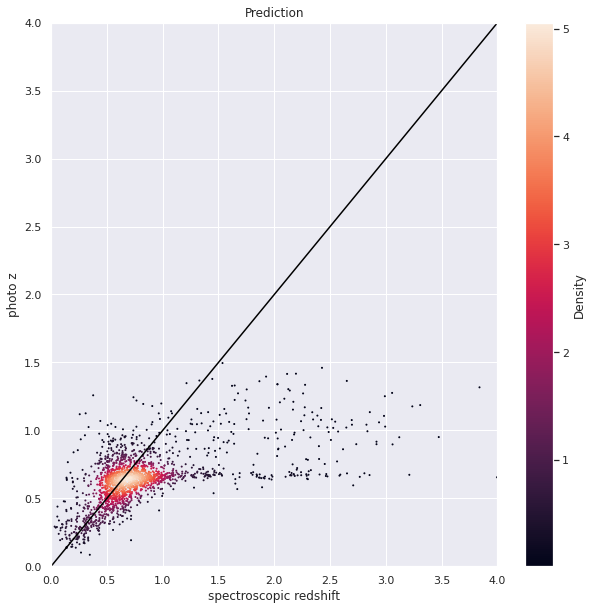

In [23]:
import seaborn as sns
z_max = 4
sns.set(rc={'figure.figsize': (10, 10), 'lines.markersize': 20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz, photoz, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

sns.set(rc={'figure.figsize':(10, 10), 'lines.markersize':20})
plt.rcParams.update({'font.size': 100})
sns.set(font_scale=3)

data = {'BCNN':10.7, 'BNN':19.7, 'Mizuki':27.4,
        'DEmP':25}
models_list = list(data.keys())
outlier_rates = list(data.values())

plt.bar(models_list, outlier_rates, color=('blue', 'red', 'red', 'red'))
plt.plot([-.5, 3.5], [15, 15], color = 'black', linestyle = 'dashed')
plt.title("Outlier Rates")
plt.ylabel("% Outlier Rate")
plt.xlabel("Model Type")
plt.show()

In [24]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0,t):
    if np.abs(specz[i]-photoz[i])<=photoz_err[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)

Coverage: 0.803


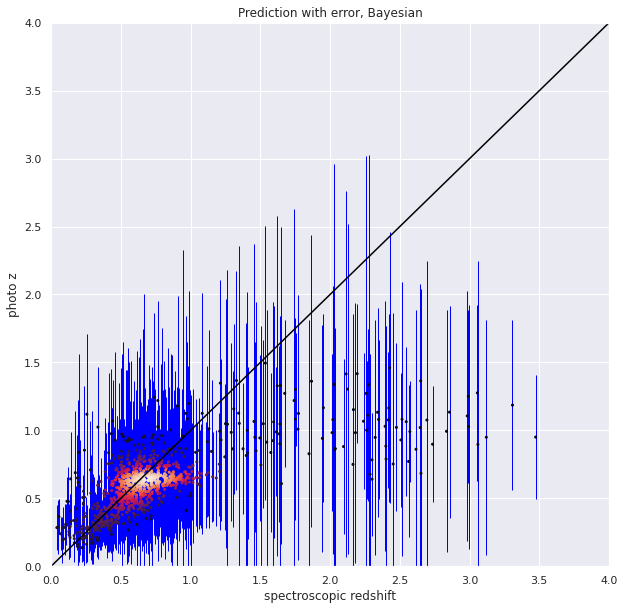

In [25]:
fig, ax = plt.subplots()
display_size = 1000
scatter_plot = ax.scatter(specz[:display_size], photoz[:display_size], c = z[:display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(specz[:display_size], photoz[:display_size], yerr = photoz_err[:display_size], fmt = "o", markersize = 0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction with error, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap_variational/t))

In [26]:
combined_array_variational = np.transpose(np.vstack((specz, photoz, photoz_err, overlap_array_variational))) 

In [27]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x: x[0])

In [28]:
bins_variational = int(z_max*5)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational, bins_variational)
coverage_variational = []
for i in range(0, bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational/len(splitted_sorted_combined_array_variational[i])/0.6827)
x_array = np.arange(0, z_max, z_max/bins_variational)

Coverage: 0.803


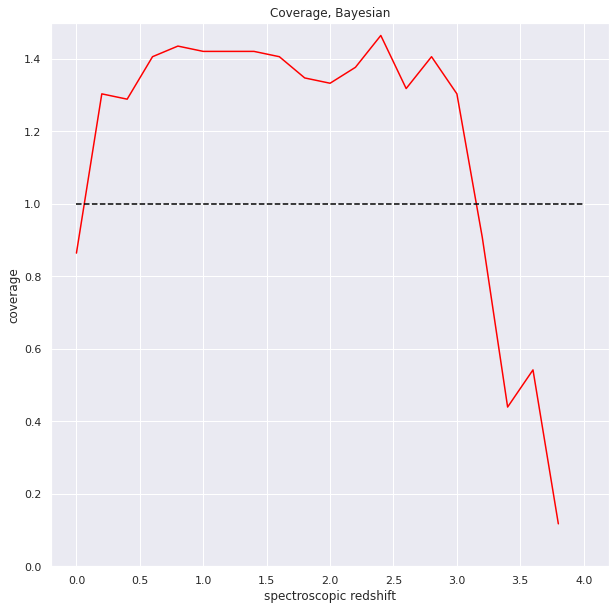

In [29]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0, 1.5])
plt.plot([0, 4], [1, 1], color = 'black', linestyle = 'dashed')
print("Coverage: "+str(overlap_variational/t))

In [30]:
mean_array = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array_variational[i])):
        bias = (splitted_sorted_combined_array_variational[i][j][1]-splitted_sorted_combined_array_variational[i][j][0])
        total += bias/(1 + splitted_sorted_combined_array_variational[i][j][0])
    mean_array.append(total/len(splitted_sorted_combined_array_variational[i]))
x_array = np.arange(0, z_max, z_max/bins_variational)

In [31]:
error_array = []
for i in range(0,bins_variational):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        error_total += splitted_sorted_combined_array_variational[i][j][2]
    error_array.append(error_total/len(splitted_sorted_combined_array_variational[i]))

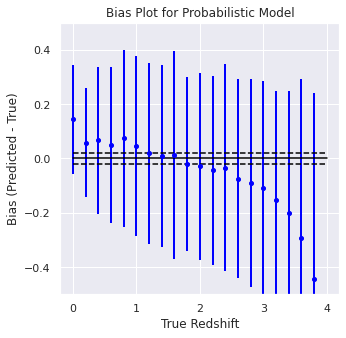

In [32]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.title('Bias Plot for Probabilistic Model')
plt.xlabel('True Redshift')
plt.ylabel('Bias (Predicted - True)')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.plot([0, z_max], [0.02, 0.02], color = 'black', linestyle = 'dashed')
plt.plot([0, z_max], [-0.02, -0.02], color = 'black', linestyle = 'dashed')
plt.ylim([-0.5, 0.5])
plt.show()

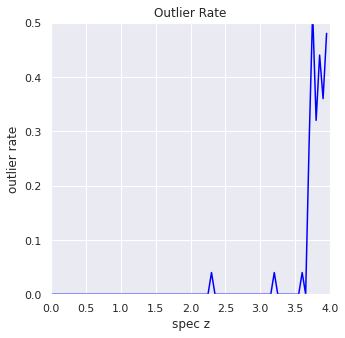

Outlier Rate: 0.0315


In [33]:
combined_outlier_array = np.transpose(np.vstack((specz, photoz, photoz_err)))
sorted_combined_outlier_array = sorted(combined_outlier_array, key=lambda x: x[0])
bins_outlier = int(z_max*20)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array,bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0,bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] - splitted_sorted_combined_outlier_array[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array[i][j][2]:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count/len(specz)*bins_outlier)
x_array_outlier = np.arange(0,z_max,z_max/bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/2])
plt.show()

print("Outlier Rate: "+str(outlier_count_total/len(specz)))

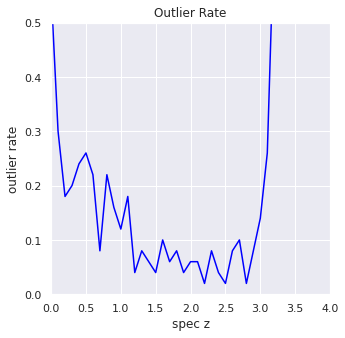

Outlier Rate: 0.276


In [34]:
combined_outlier_array = np.transpose(np.vstack((specz,np.subtract(photoz, specz))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key=lambda x: x[0])
bins_outlier = int(z_max*10)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array,bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0,bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1]/(splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count/len(specz)*bins_outlier)
x_array_outlier = np.arange(0,z_max,z_max/bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/2])
plt.show()

print("Outlier Rate: "+str(outlier_count_total/len(specz)))

In [35]:
photoz_utils.save_with_oid_std(model_name, object_id, specz, photoz, photoz_err)
# photoz_utils.save_train_with_oid_std(model_name, object_id_train, specz_train, photoz_train, photoz_err_train)
# photoz_utils.save_validation_with_oid_std(model_name, object_id_validation, specz_validation, photoz_validation, photoz_err_validation)

In [36]:
uncertains = []
for i in range(0, len(photoz_err)):
    if photoz_err[i].numpy() >= 1:
        uncertains.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

AttributeError: 'numpy.float32' object has no attribute 'numpy'

In [ ]:
check = 2
current = uncertains[check]
print("Object ID: " + str(object_id[current]) + ", Spectro_z: " + str(specz[current]) + ", Photo_z: " + str(photoz[current]) + ", Photo_z_err: " + str(photoz_err[current].numpy()))
plt.imshow(x_test[current][:,:,0])
plt.grid(False)

In [ ]:
biases = []
for i in range(0, len(photoz)):
    if np.abs(photoz[i]-specz[i]) >= 1 and photoz_err[i].numpy() <= 0.5:
        biases.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

In [ ]:
check_bias = 3
current_bias = biases[check_bias]
print("Object ID: " + str(object_id[current_bias]) + ", Spectro_z: " + str(specz[current_bias]) + ", Photo_z: " + str(photoz[current_bias]) + ", Photo_z_err: " + str(photoz_err[current_bias].numpy()))
plt.imshow(x_test[current_bias][:,:,0])
plt.grid(False)

In [ ]:
# END